In [1]:
!date

Wed Oct 25 14:44:14 EDT 2023


# Grab lake contours bigger than 5 degrees - no time tracking
## Make distance and direction field, lake by lake (that is, time by time)
#### from all available datafiles with a couple hundred hours in them
#### resulting filenames end in distance.nc

------------


In [241]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os         
#from descartes.patch import PolygonPatch

from shapely.geometry import Point
from shapely.ops import nearest_points
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

from glob import glob
import xarray as xr
#import dask.array as da

import pandas as pd
import geopandas as gp
from datetime import datetime

In [3]:
files = glob('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/*distance.nc')

In [4]:
# Make directories for the outputs 

for ifile in range( len(files) ):  
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+'/TIMELEVELS/'
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+'/TIMELEVELS/'+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)
    print(pathpath)

/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_03_21_09_lat5p130N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_03_21_09/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_18_lat1p979S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2017_05_06_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_04_30_02_lat0p276N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_04_30_02/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_05_11_18_lat2p131S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2014_05_11_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2018_03_19_12_lat9p318S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIM

In [5]:
file = files[0]
path = file[0:67]+"TIMELEVELS/"
os.makedirs(path, exist_ok=True)
path

'/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/'

In [74]:
# CRS warnings are annoying below, I might suppress all just for readability

import warnings
warnings.filterwarnings("ignore")

# A function to return a GeoDataFrame of polygons 

In [6]:
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9] # needs a second level for some reason, infinity
    cs = plt.contourf(lon,lat,tqv,levels) 
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
    i=0 # initialize a counter 
    
    for col in cs.collections:
        z=lvl_lookup[col] # the value of the contour isopleth
        for contour_path in col.get_paths():
#        print('contour path: ',i)

        # create the multipolygon for this value of the field
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
            gdf = gp.GeoDataFrame(geometry=polylist)
            gdf['tqv_values']=zvalues
        
    return(gdf)

------------

# Open each dataset in xarray, and loop over all times in it

In [8]:
MINSIZE = 5 # square degrees, smallest area lake (closed contour at an instant) to process 

In [243]:
# Function to calculate nonzero distances from points to a polygon
def calculate_nonzero_distance(point, polygon):
    nearest_point = nearest_points(point, polygon.exterior)[1]  # Get the nearest point on the polygon's boundary
    nonzero_distance = point.distance(nearest_point)
    return nonzero_distance

In [ ]:
all_gdflakes = [] # collect them all in one big set of single closed contours ("lakes") 

for nfile,ifile in enumerate( range( len(files) ) ):  
#for nfile,ifile in enumerate( range(1) ):
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(nfile, file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+"/TIMELEVELS/"
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+"/TIMELEVELS/"+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)

    bigds = xr.open_dataset(file)
    
    # Make an array of Points that are the gridpoints of MERRA2 in this file
    lat2d = bigds.lat.values[:,None]   + bigds.lon.values*0
    lon2d = bigds.lat.values[:,None]*0 + bigds.lon.values
    points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] )\
            .set_crs(epsg = "4256", inplace = True)
     
# TIME LOOP OVER ALL TIMES: SLICE OFF ds DATASET - 2D ONLY
    for itime in range(len(bigds.time)): 
    #for itime in range(1): 

        print('time: ',itime)
        ds = bigds.isel(time=itime).drop_vars(['distance','dir_from_centroid'])
        gdf = gdf_from_contours(ds.lon,ds.lat,ds.tqv, 55.)
        
# Iterate over rows in the GeoDataFrame
        for i, row in gdf.iterrows():
    # Create a DataFrame containing the current row
            single_row_df = gdf.iloc[[i]]
    
    # Convert the DataFrame back to a GeoDataFrame
            lake = gp.GeoDataFrame(single_row_df, geometry='geometry').set_crs(epsg = "4256", inplace = True)            
            
            # don't count it if the contour touches the edge of the dataset
            inbounds = \
                (lake.geometry.bounds.minx > ds.lon.min().values) & (lake.geometry.bounds.maxx < ds.lon.max().values) & \
                (lake.geometry.bounds.miny > ds.lat.min().values) & (lake.geometry.bounds.maxy < ds.lat.max().values)
            
            if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ): 
                lake['perimeter']=lake.geometry.length
                lake['area']=lake.geometry.area
                lake['centroidlat']=lake.geometry.centroid.y
                lake['centroidlon']=lake.geometry.centroid.x
                lake['centriod_is_inside']= lake.geometry.contains(lake.geometry.centroid)
                lake['maxlon']=lake.geometry.bounds.maxx
                lake['minlon']=lake.geometry.bounds.minx
                lake['maxlat']=lake.geometry.bounds.maxy
                lake['minlat']=lake.geometry.bounds.miny
                lake['contournum']= i
                ## gdf_1.geometry.apply(lambda g: gdf_2.distance(g))

            # Compute distance field from perimeter: What a Pain! 
                #dist = points.distance(lake.geometry.boundary).values.reshape(len(ds.lat),len(ds.lon)) # NaN problem !!?? dammit
                #isin = points.within(lake.geometry).values.reshape(len(ds.lat),len(ds.lon)) # perhaps the Nan problem too 
                #dist = points.geometry.apply(lambda g: lake.exterior.distance(g)).values.reshape(len(ds.lat),len(ds.lon)) # slow dammit but works 
                #dist = lake.geometry.apply(lambda g: points.distance(g)).values.reshape(len(ds.lat),len(ds.lon)) # Fast gives zero inside
                
# Calculate signed distances for points using the apply method
                nonzero_distances = points.apply(lambda point: calculate_nonzero_distance(point, lake))
# Reshape the result into a 2D NumPy array
                dist = np.array(nonzero_distances).reshape(len(ds.lat), len(ds.lon))
# flip sign of distance inside the lake
                isin = points.geometry.apply(lambda g: lake.contains(g)).values.reshape(len(ds.lat),len(ds.lon))
                dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 
                
# Direction to centroid of WHOLE LAKE at this time
                centlon = lake.centroidlon
                centlat = lake.centroidlat 
# use j in explicit loop over gridpoints, since geodesic takes scalar only. Inelegant but works. 
                dir_to = []
                for j in range(len(lon2d.ravel())): 
                    fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[j], lat2d.ravel()[j], [centlon], [centlat])
                    dir_to.append(fwd_az+180)
                
                dist_to = np.array(dist).reshape(len(ds.lat),len(ds.lon))
                dir_to = np.array(dir_to).reshape(len(ds.lat),len(ds.lon))
        
                command = "ds = ds.assign(distance"+str(i)+"=(['lat','lon'],dist))"
                #print(command)
                exec(command)
                command = "ds = ds.assign(dir_to"+str(i)+"=(['lat','lon'],dir_to))"
                #print(command)
                exec(command)
                lake['filename'] = datestr+'_time'+str(itime)+'_distdirs.nc'
                all_gdflakes.append(lake) # giant list of all lakes at all times in all files 
                
                # Output all the distance and dir_to for this time level for this dataset    
                ds.to_netcdf(pathpath+datestr+'_time'+str(itime)+'_distdirs.nc')
                ds.close()
                print('Writing netCDF, all_gdflakes is up to ', len(all_gdflakes))

            else: 
                print('out of bounds or too small ',i)
                

# write geojson of lakes at this time into one file 

all_lakes = pd.concat(all_gdflakes)
with open('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/AllLakeContours_2014-2018.geojson', 'w') as f:
    f.write(all_lakes.to_json())
f.close()

0 /Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_18_lat1p979S.M2_min2D_distance.nc
time:  0
out of bounds or too small  0
out of bounds or too small  1
Writing netCDF, all_gdflakes is up to  242
out of bounds or too small  3
out of bounds or too small  4
Writing netCDF, all_gdflakes is up to  243
out of bounds or too small  6
Writing netCDF, all_gdflakes is up to  244
out of bounds or too small  8
out of bounds or too small  9
out of bounds or too small  10


In [251]:
signed_distances.size

3552

In [252]:
61*78

4758

<AxesSubplot:>

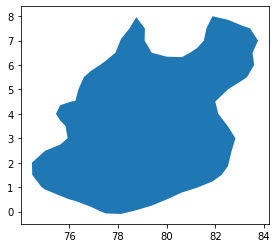

In [245]:
# Debugging "within" 
lake.geometry.plot()

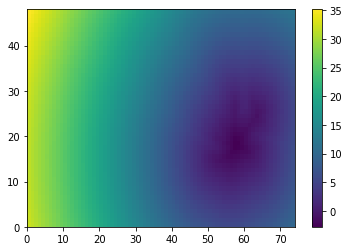

In [246]:
plt.pcolormesh(dist.reshape(len(ds.lat),len(ds.lon)) ); plt.colorbar()  #[dist < 0.1]

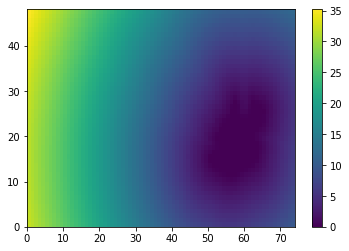

In [237]:
dist = lake.geometry.apply(lambda g: points.distance(g)).values.reshape(len(ds.lat),len(ds.lon)) # Fast gives zero inside
plt.pcolormesh(dist.reshape(len(ds.lat),len(ds.lon)) ); plt.colorbar()  #[dist < 0.1]

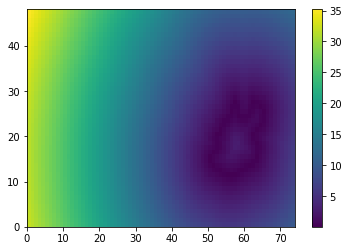

In [236]:
dist = points.geometry.apply(lambda g: lake.exterior.distance(g)).values.reshape(len(ds.lat),len(ds.lon)) # slow dammit but works 
plt.pcolormesh(dist.reshape(len(ds.lat),len(ds.lon)) ); plt.colorbar()  #[dist < 0.1]

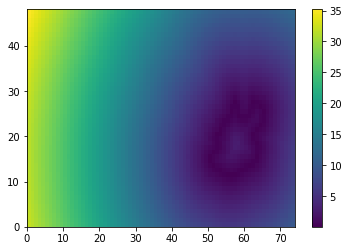

In [240]:
# GPT suggests this : less slow,... and successful!! 
import numpy as np
from shapely.ops import nearest_points

# Assuming lake is your GeoDataFrame containing the lake polygon
# Assuming points is your GeoSeries of points

# Function to calculate signed distances
def calculate_signed_distance(point, polygon):
    nearest_point = nearest_points(point, polygon.exterior)[1]  # Get the nearest point on the polygon's boundary
    signed_distance = point.distance(nearest_point)
    return signed_distance

# Calculate signed distances for points using the apply method
signed_distances = points.apply(lambda point: calculate_signed_distance(point, lake))

# Reshape the result into a 2D NumPy array
dist = np.array(signed_distances).reshape(len(ds.lat), len(ds.lon))

plt.pcolormesh(dist.reshape(len(ds.lat),len(ds.lon)) ); plt.colorbar()  #[dist < 0.1]

In [83]:
all_lakes

,geometry,tqv_values,perimeter,area,centroidlat,centroidlon,centriod_is_inside,maxlon,minlon,maxlat,minlat,contournum,filename
2,"POLYGON ((77.50000 -0.07628, 78.12500 -0.09535...",55.0,31.399599,45.106214,3.639200,79.243520,True,83.744648,74.467127,7.995595,-0.095354,2,2015_03_21_09_time0_distdirs.nc
2,"POLYGON ((77.50000 -0.05237, 78.12500 -0.08570...",55.0,30.860328,44.962038,3.645234,79.042406,True,83.450412,74.254443,8.050020,-0.085704,2,2015_03_21_09_time1_distdirs.nc
2,"POLYGON ((77.50000 -0.01616, 78.12500 -0.05611...",55.0,31.307608,45.122587,3.686512,78.867482,True,83.174937,74.187793,8.091238,-0.056109,2,2015_03_21_09_time2_distdirs.nc
2,"POLYGON ((77.50000 -0.00889, 78.12500 -0.03848...",55.0,31.018840,45.168664,3.713342,78.729919,True,83.120122,74.173566,8.118998,-0.038477,2,2015_03_21_09_time3_distdirs.nc
1,"POLYGON ((77.50000 -0.04742, 78.12500 -0.05558...",55.0,31.849676,45.280985,3.688012,78.554336,True,83.102678,74.095983,8.138381,-0.055576,1,2015_03_21_09_time4_distdirs.nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,"POLYGON ((40.57589 -13.00000, 40.31280 -12.500...",55.0,59.120807,87.219707,-5.376174,43.920431,True,53.802759,37.321969,0.601695,-13.039636,1,2016_04_15_08_time284_distdirs.nc
3,"POLYGON ((38.75000 -8.46314, 38.12500 -8.28866...",55.0,48.421824,79.190027,-5.003732,44.041455,True,53.772788,37.305794,0.816097,-8.942952,3,2016_04_15_08_time285_distdirs.nc
4,"POLYGON ((39.01614 -8.50000, 38.75000 -8.36040...",55.0,51.224529,73.846356,-5.126232,43.937754,True,53.782141,37.376869,1.093738,-8.814217,4,2016_04_15_08_time286_distdirs.nc
2,"POLYGON ((40.33577 -12.00000, 40.16523 -11.500...",55.0,62.975449,77.367976,-5.471706,43.534630,True,53.796583,37.412897,1.329756,-12.139597,2,2016_04_15_08_time287_distdirs.nc


In [84]:
df = all_lakes

-------------
# Composite rain by distance from contour for selected ones

In [85]:
df = gp.read_file('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/AllLakeContours_2014-2018.geojson')

In [93]:
# Big ones with short perimeters
bigrounds = df[(df.area > 300) & (df.perimeter < 200)]
bigrounds.area.values

array([305.02790091, 308.09204288, 307.71308176, 307.97633429,
       308.05106868, 309.28026525, 305.63556261, 309.77582354,
       306.61788745, 308.21256743, 309.14987596, 307.93744879])

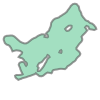

In [99]:
bigrounds.geometry.values[0]

In [100]:
bigrounds.contournum.values[0]

1

In [96]:
bigrounds.filename.values[0]

'2017_05_09_01_time200_distdirs.nc'

In [97]:
fi = '/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/'+\
    bigrounds.filename.values[0][0:13]+'/'+bigrounds.filename.values[0]
fi

'/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/2017_05_09_01/2017_05_09_01_time200_distdirs.nc'

### 

In [98]:
ds = xr.open_dataset(fi)
ds

<xarray.Dataset>
Dimensions:    (lat: 79, lon: 85)
Coordinates:
    time       datetime64[ns] ...
  * lat        (lat) float64 -20.5 -20.0 -19.5 -19.0 ... 17.0 17.5 18.0 18.5
  * lon        (lon) float64 33.12 33.75 34.38 35.0 ... 83.75 84.38 85.0 85.62
Data variables:
    prectot    (lat, lon) float32 ...
    tqv        (lat, lon) float32 ...
    distance1  (lat, lon) float64 ...
    dir_to1    (lat, lon) float64 ...
    distance2  (lat, lon) float64 ...
    dir_to2    (lat, lon) float64 ...
    distance4  (lat, lon) float64 ...
    dir_to4    (lat, lon) float64 ...
Attributes:
    title:        MERRA-2 tavg1_2d_flx_Nx: 2d,1-Hourly,Time-Averaged,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Wed May 24 22:31:24 GMT 2023 : imported by GrADS Data Serve...

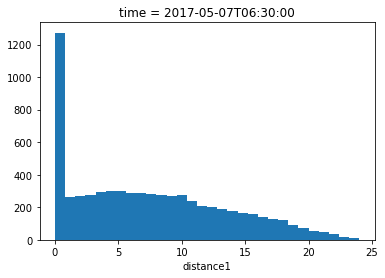

In [107]:
ds.distance1.plot.hist(bins=30);

In [102]:
ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean()

<xarray.Dataset>
Dimensions:         (distance1_bins: 149)
Coordinates:
  * distance1_bins  (distance1_bins) object (-5.0, -4.9] ... (9.8, 9.9]
    time            datetime64[ns] 2017-05-07T06:30:00
Data variables:
    prectot         (distance1_bins) float32 nan nan nan ... 8.74e-05 5.056e-05
    tqv             (distance1_bins) float32 nan nan nan ... 43.81 45.02 43.76
    distance1       (distance1_bins) float64 nan nan nan ... 9.658 9.749 9.853
    dir_to1         (distance1_bins) float64 nan nan nan ... 207.7 247.2 235.1
    distance2       (distance1_bins) float64 nan nan nan ... 23.81 18.1 21.12
    dir_to2         (distance1_bins) float64 nan nan nan ... 87.38 110.4 96.24
    distance4       (distance1_bins) float64 nan nan nan ... 19.28 12.46 16.54
    dir_to4         (distance1_bins) float64 nan nan nan ... 116.4 177.3 143.8

Text(0.5, 1.0, 'PW-40 (mm) and MERRA2 prectot (mm/d) 2017_05_09_01_time200_distdirs.nc')

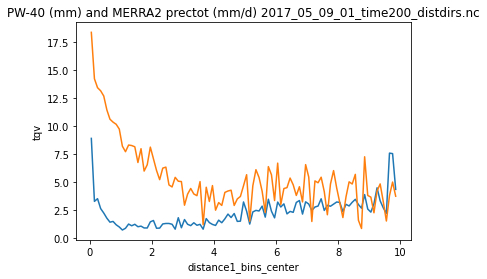

In [103]:
(ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean().prectot*86400.).plot() # mm/d
(ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean().tqv -40).plot() # inches
plt.title('PW-40 (mm) and MERRA2 prectot (mm/d) '+bigrounds.filename.values[0])

In [ ]:
# From Snigdha 

def process_one_time_slice(ds_t):
    # Check if all values in 'distance0' are NaN
    if np.all(np.isnan(ds_t['distance0'])):
        return None  # Return None if all values are NaN
    
    # Group the data by distance bins, ranging from -2 to 4 with intervals of 0.1
    ds_grouped_t = ds_t.groupby_bins('distance0', bins=np.arange(-2.0, 4.0, 0.1))
    
    # Initialize a list to hold individual binned DataArrays
    binned_data_list = []
    bin_names = []
    # Loop through each distance bin group
    for name, group in ds_grouped_t:
        # Use the bin name as a coordinate
        group['binned_distance'] = str(name)
        
        # Append the group to the list
        binned_data_list.append(group)
        bin_names.append(str(name))
    
    # Concatenate along a new dimension 'binned_distance'
    ds_reduced_t = xr.concat(binned_data_list, dim=xr.DataArray(bin_names, name='binned_distance', dims='binned_distance'))
  
    # Return the reduced dataset for this time slice
    return ds_reduced_t